# Week 4 Seminar.

## Chapter 5. Resampling Methods: Bootstrap, CV.

### Course: ML with Python, 2024/2025, HSE
### Author: Boris Tseytlin, Teaching Team.



This week we will be covering two resampling techniques you can use to asses your machine learning models:
* Cross-Validation
* Bootstrap

In [ ]:
# let the statsmodels library to be consistent with latest pandas

# !pip -q install --upgrade statsmodels

In [ ]:
import numpy as np, pandas as pd, matplotlib.pylab as plt, seaborn as sns, statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold, ShuffleSplit, \
  StratifiedKFold, GroupShuffleSplit, GroupKFold, StratifiedShuffleSplit
from matplotlib.patches import Patch

# Increase viewable area of Pandas tables, numpy arrays, plots
pd.set_option('display.max_rows', 15, 'display.max_columns', 500, 'display.max_colwidth', 1, 'display.precision', 2)
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)

In [ ]:
sns.set_theme()

In [ ]:
plt.rcParams['figure.figsize'] = [16, 6]

# Loading data

We will load the Titanic dataset, perform the same preprocessing as we did on week 3, and train a simple model.

In [ ]:
csv_url = 'https://raw.githubusercontent.com/omelnikov/data/main/titanic/titanic.csv'
df = pd.read_csv(csv_url)
df.columns=['psgr','srv','pcls','name','sex','age','sibsp','parch','tkt','fare','cabin','emb']
df.sex = 1*(df.sex=='male')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   psgr    891 non-null    int64  
 1   srv     891 non-null    int64  
 2   pcls    891 non-null    int64  
 3   name    891 non-null    object 
 4   sex     891 non-null    int64  
 5   age     714 non-null    float64
 6   sibsp   891 non-null    int64  
 7   parch   891 non-null    int64  
 8   tkt     891 non-null    object 
 9   fare    891 non-null    float64
 10  cabin   204 non-null    object 
 11  emb     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


In [ ]:
# Ignore cabin & ticket numbers, as well as passenger name for prediciton
df_filtered = df.drop(['cabin', 'tkt', 'name'], axis=1)

# Use a product trick to convert categorical features `emb`
# with three posible values to two binary features
df_filtered["emb_is_S"] = (df_filtered["emb"] == "S").astype(int)
df_filtered["emb_is_C"] = (df_filtered["emb"] == "C").astype(int)

# Drop unnecessary feature - we can derive it from `emb_is_S` or `emb_is_C`
df_filtered = df_filtered.drop(["emb"], axis=1)

median_age = df_filtered["age"].median()
print("Filling NA values with age", median_age)
df_filtered = df_filtered.fillna(median_age)

fare_max = df_filtered['fare'].quantile(0.95) # extract 95% percentile of fare
df_filtered.loc[df_filtered['fare'] > fare_max, "fare"] = fare_max # replace too high values with percentile

sibsp_max = df_filtered['sibsp'].quantile(0.95) # extract 95% percentile of sibsp
df_filtered.loc[df_filtered['sibsp'] > sibsp_max, "sibsp"] = sibsp_max # replace too high values with percentile

Filling NA values with age 28.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered.drop(["srv"], axis=1), df_filtered["srv"], test_size=0.3,
) # Split data onto train and test subsets

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred)
print('ROC AUC', score)

ROC AUC 0.5846446011937059


We obtained some ROC AUC score for our classifier. However, if we rerun this cell a few times, we will get different results.
Let's confirm that:

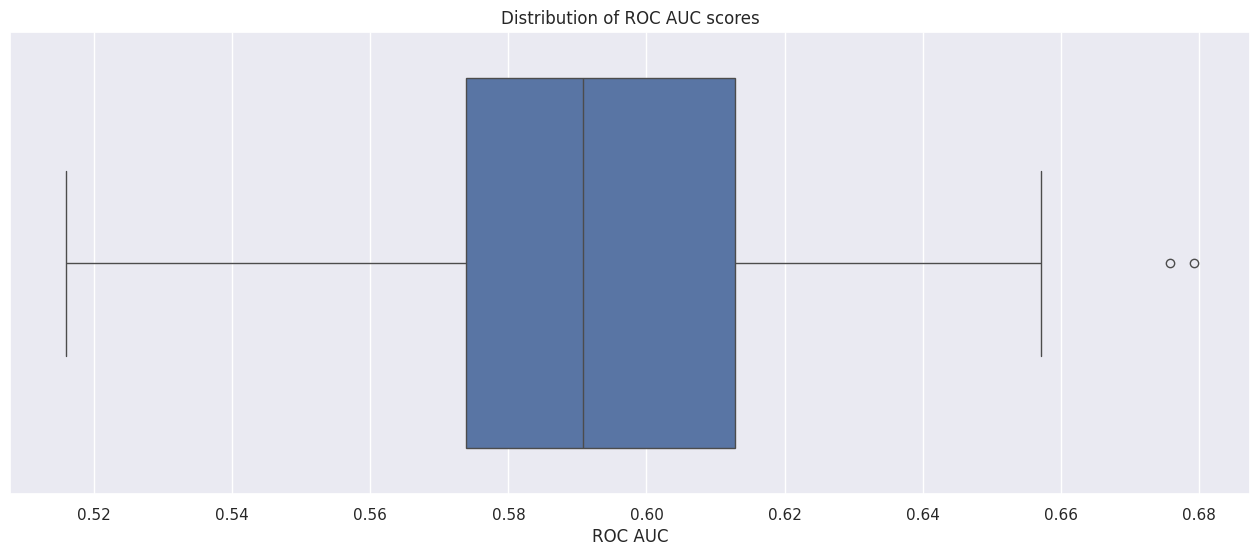

In [ ]:
scores = []
for i in range(250):
    X_train, X_test, y_train, y_test = train_test_split(
        df_filtered.drop(["srv"], axis=1), df_filtered["srv"], test_size=0.3 )

    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    scores.append(roc_auc_score(y_test, y_pred))

plt.figure()
sns.boxplot(x=scores)
plt.title('Distribution of ROC AUC scores')
plt.xlabel('ROC AUC')
plt.show()

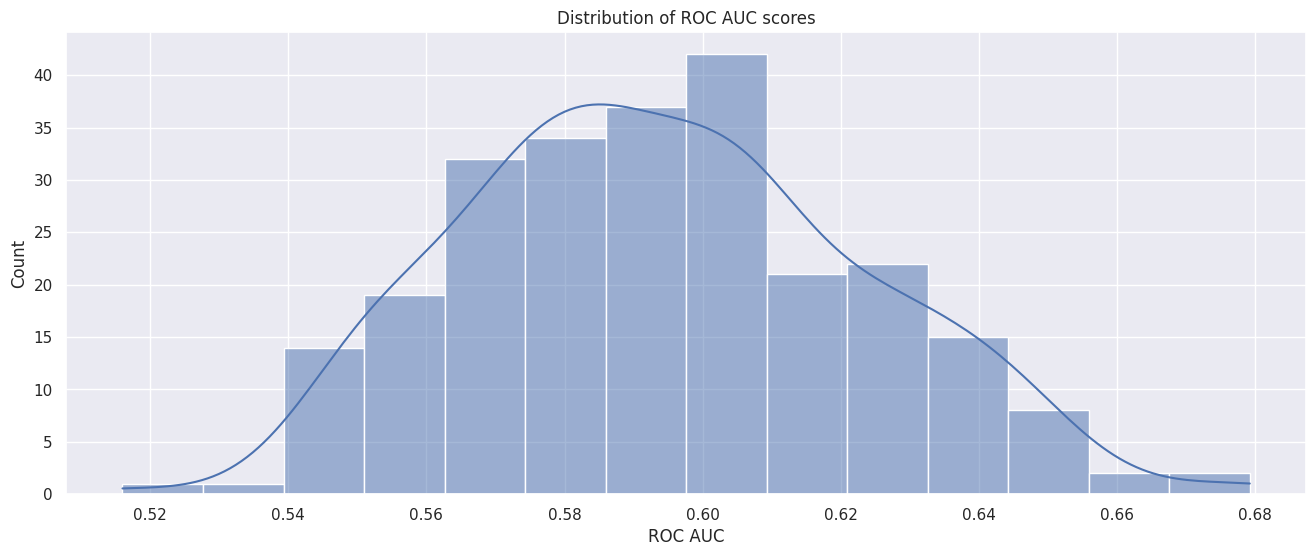

In [ ]:
plt.figure()
sns.histplot(scores, kde=True)
plt.title('Distribution of ROC AUC scores')
plt.xlabel('ROC AUC')
plt.show()

The scores can vary up to 0.1 in absolute value between different runs!

**Takeaway:**
The performance of a model is heavily dependant on the train-test split.

Therefore we can't use train-test splits to get reliable estimates of model performance. That also means that we can't use them to reliably find the best hyperparameters (like the $k$ parameter for KNN).

We want to know how good our model is **overall**.  We would like a method that does not depend on one exact data split. It should be realiable and reasonably fast. Such a method exists and it's called Cross-Validation.



# Cross-Validation

The idea behind Cross-Validation:
1. Perform multiple splits.
2. For each split, fit a model to the training set, predict and compute a score (e.g. accuracy) on the validation set.
3. Average the results, obtain confidence intervals.

There are many ways to perform the first step. In general, you want each observation to appear in at least one validation set.

For maximum reliability, you could make as many splits as you have observations ($N$). But this is very slow, because you have to fit $N$ models. So instead you might want to make a few non-overlapping splits with $k < N$ observations in each, so that you can fit fewer models and achieve similar results. We will try these and other methods below.

Cross-validation can be used for:
* Obtaining a reliable estimate of test set error.
* Comparing models in terms of performance.
* Finding the best values for hyperparameters.

Source of plotting helpers: [sklearn docs](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

### Some plotting helpers

In [ ]:
np.random.seed(0)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

def draw_bars(bars, y=0.5, vmin=-.2, vmax=1.2, label=None):
    ax = plt.gca()
    ax.scatter(range(len(bars)),  [y] * len(bars), c=bars, marker='_',
               lw=50, label=label, cmap=cmap_cv, vmin=vmin, vmax=vmax)

## Train-test split visualized

First of all, let's take a look at our train-test split.

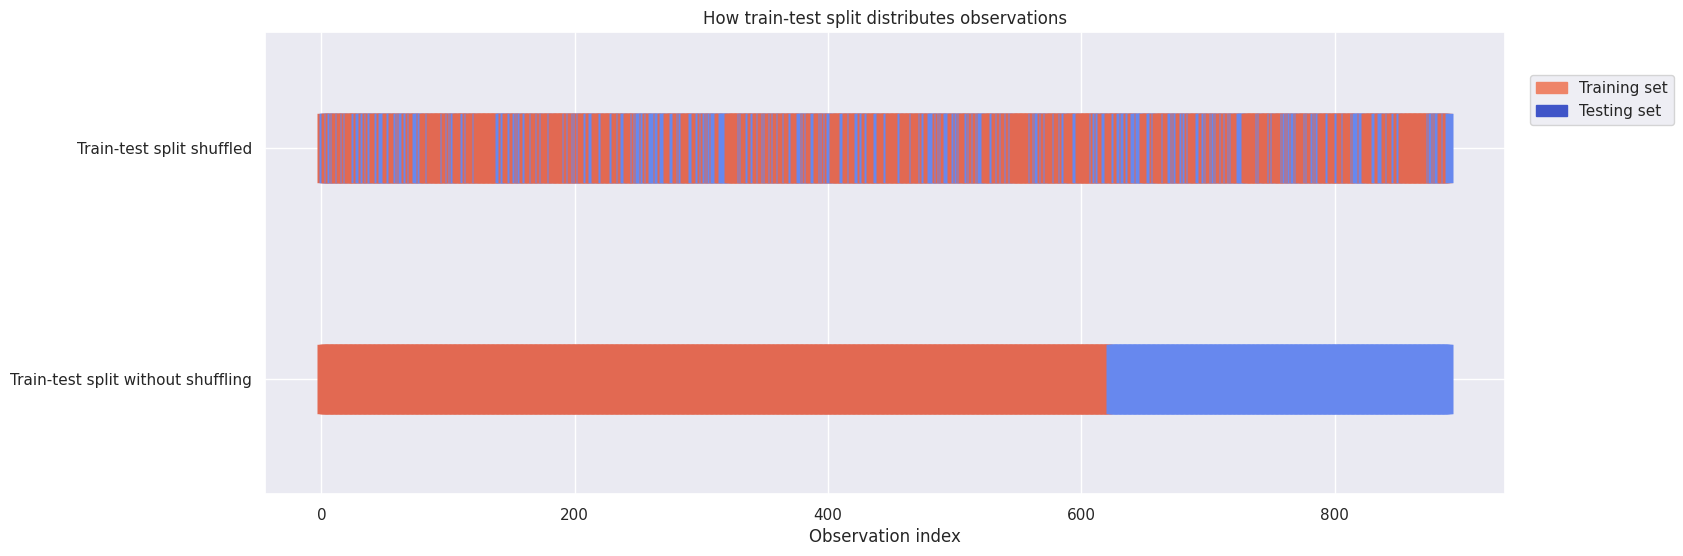

In [ ]:
train_idx, test_idx = train_test_split(df_filtered.index, test_size=0.3, shuffle=False)
idx_labels = np.array([(idx in train_idx) for idx in df_filtered.index])

train_idx, test_idx = train_test_split(df_filtered.index, test_size=0.3)
idx_labels_shuffled = np.array([(idx in train_idx) for idx in df_filtered.index])

plt.figure()
draw_bars(idx_labels, y=0.5)
draw_bars(idx_labels_shuffled, y=1.5)
plt.xlabel('Observation index')
plt.yticks([0.5, 1.5], ['Train-test split without shuffling', 'Train-test split shuffled'])
plt.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Training set', 'Testing set'], loc=(1.02, .8))

plt.ylim([0, 2])
plt.title('How train-test split distributes observations')
plt.show()

## K-Fold Cross-Validation

Idea: split dataset into $K$ **non-overlapping** groups. Each of the $K$ groups is used as a validation set once, while the other $K-1$ groups are used as the training set.

No shuffling is done by default, but usually it's good to do it as well.

In [ ]:
def plot_cv_splits(cv, index, title, y=None, groups=None):
    plt.figure()

    y_ticks_pos = []
    y_ticks = []
    for i, (train_idx, test_idx) in enumerate(cv.split(index, y=y, groups=groups)):
        idx_labels = np.array([(idx in train_idx) for idx in index])
        draw_bars(idx_labels, y=0.5+i)
        y_ticks_pos.append(0.5+i)
        y_ticks.append(f'Fold {i}')

    if y is not None:
        i += 1
        draw_bars(y, y=0.5+i, vmin=0.5, vmax=0.8)
        y_ticks_pos.append(0.5+i)
        y_ticks.append(f'Class')

    plt.xlabel('Observation index')
    plt.yticks(y_ticks_pos, y_ticks)
    plt.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
                ['Training set', 'Testing set'], loc=(1.02, .8))

    plt.ylim([0, i+1])
    plt.title(title)
    plt.show()

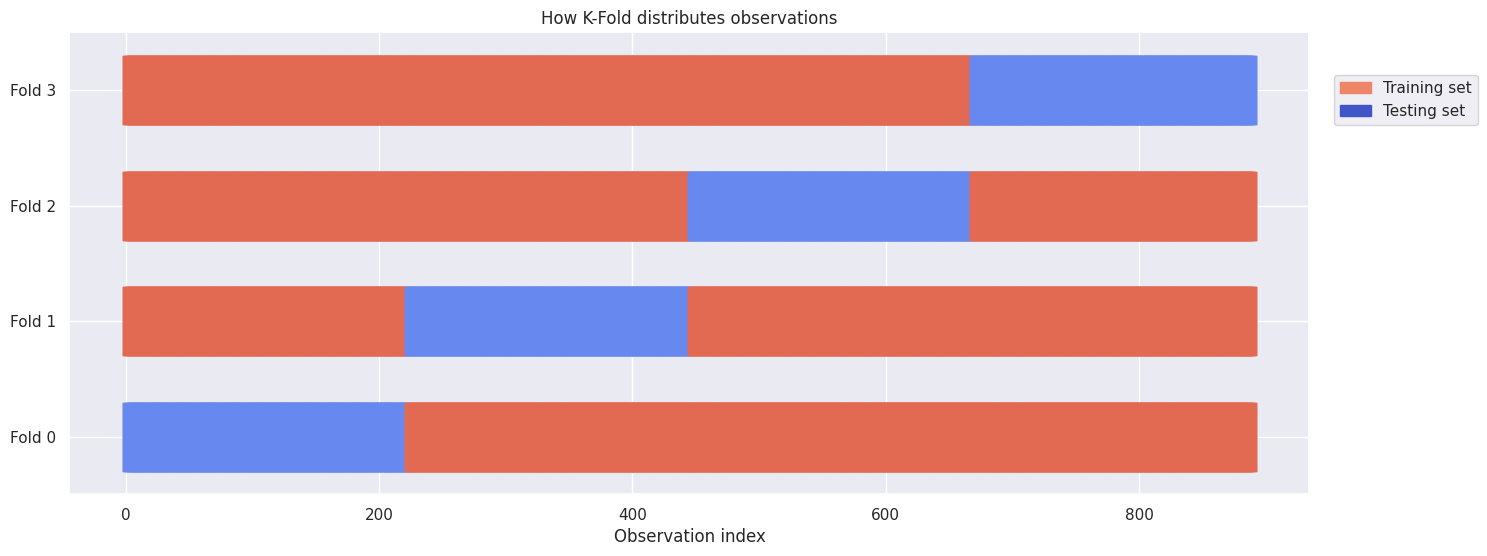

In [ ]:
cv = KFold(n_splits, shuffle=False)
plot_cv_splits(cv, df_filtered.index, 'How K-Fold distributes observations')

**Exercise:** implement your own K-Fold cross-validation



In [ ]:
def simple_generator(n):
    for i in range(n):
        yield i

In [ ]:
a = simple_generator(10)

In [ ]:
type(a)

generator

In [ ]:
next(a)

StopIteration: 

In [ ]:
for i in a:
    print(i)

0
1
2
3
4
5
6
7
8
9


In [ ]:
syn = np.array(range(10))
syn

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.random.shuffle?

In [ ]:
arr = np.arange(9).reshape((3, 3))
arr

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [ ]:
np.random.shuffle(arr)
arr

array([[3, 4, 5],
       [0, 1, 2],
       [6, 7, 8]])

### Solution:

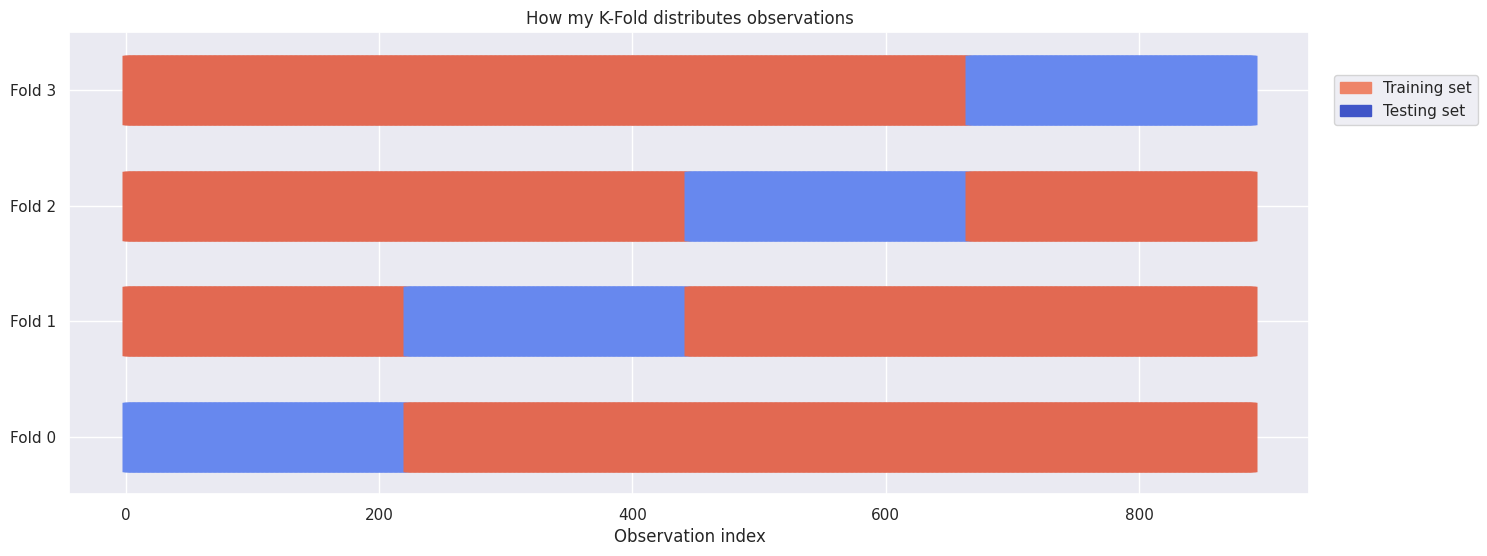

In [ ]:
class MyKFold:
    def __init__(self, n_splits, shuffle=False):
        self.n_splits = n_splits
        self.shuffle = shuffle

    def split(self, x, *args, **kwargs):
        if self.shuffle:
            x = np.array(x)
            np.random.shuffle(x)

        length = len(x)
        cnt_in_split = length // self.n_splits
        for i in range(self.n_splits):
            start_index = i*cnt_in_split
            end_index = (i+1)*cnt_in_split
            if (i+2)*cnt_in_split > length:
                end_index = length
            val = x[start_index:end_index]
            train_start = x[:start_index]
            train_end = x[end_index:]
            train = np.concatenate([train_start, train_end])

            yield train, val

my_cv = MyKFold(n_splits, False)
plot_cv_splits(my_cv, df_filtered.index, 'How my K-Fold distributes observations')

## Stratified K-Fold

K-Fold is great, but let's take a look at how it handles the classes of Titanic. I sort the target so that the plot is more illustrative.

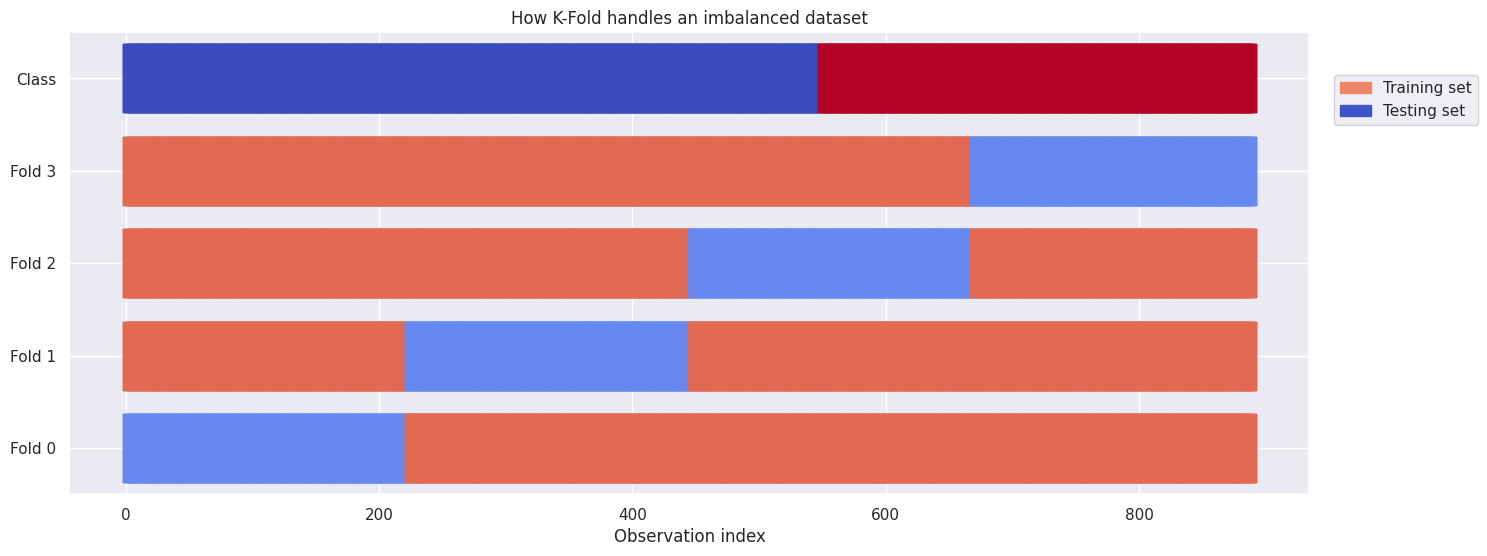

In [ ]:
plot_cv_splits(cv, df_filtered.index, 'How K-Fold handles an imbalanced dataset', y=sorted(df_filtered['srv']))

This is not good: folds are going to have a different distribution of classes in them. We want to preserve the class distribution, so that our models can learn something actually useful.

**Stratified K-fold** makes sure that the original class distribution is preserved in each fold.

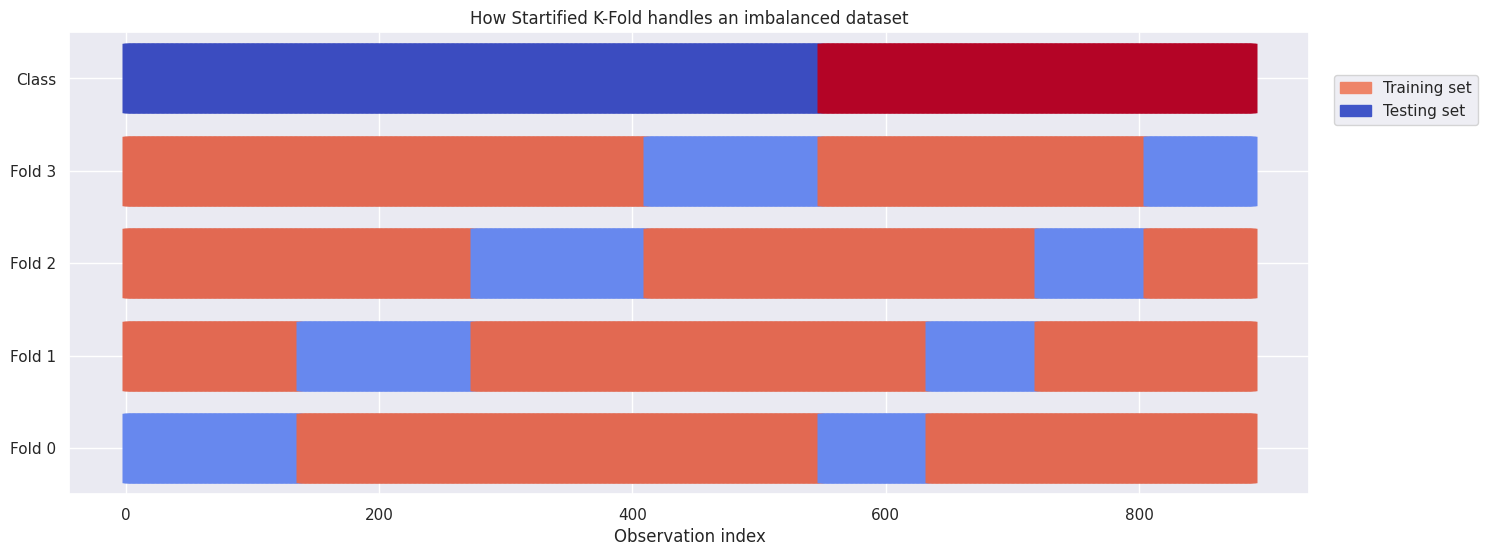

In [ ]:
cv = StratifiedKFold(n_splits, shuffle=False)
plot_cv_splits(cv, df_filtered.index, 'How Startified K-Fold handles an imbalanced dataset', y=sorted(df_filtered['srv']))

## Other notable CV methods available in sklearn

* [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold) - same as K-Fold, except but you can define groups of observations. Observations of some group will always appear in either training or validation set, but never in different sets.

* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit) - the training sets are always in the past and the validation sets are always in the future, so that you are never training on the future to predict the past.

More [here](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

## Optimizing hyperparameters with CV

Remember how we were looking for the best $k$ value in the previous seminars? Previously we were simply trying some $k$ values on the same train-test split and seeing what worked best. It wasn't very reliable: perhaps the selected $k$ is only good for this exact split.


Now that we know about CV, let's do the following:
* Choose some $k$ value.
* For this value, run cross-validation and compute the mean ROC AUC.
* Pick the best $k$ value based on the best obtained ROC AUC.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered.drop(["srv"], axis=1), df_filtered["srv"], test_size=0.3, random_state=0,
)

In [ ]:
cv = StratifiedKFold(n_splits=5)

# n_jobs=-1 -> uses all available CPU cores to speed up computation
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier(n_jobs=-1,))
    ])

# clf__weights -> Contribution of each neighbors...
# ...(uniform -> equaly, distance -> closer more contribution)
# verbose -> controls the output informations
params = {'clf__n_neighbors': range(1, 11), 'clf__weights':['uniform', 'distance']}
search = GridSearchCV(pipe, cv=cv, param_grid=params, n_jobs=-1, verbose=10, scoring='roc_auc')

In [ ]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': range(1, 11),
                         'clf__weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=10)

In [ ]:
search.best_estimator_, search.best_score_

(Pipeline(steps=[('scale', StandardScaler()),
                 ('clf',
                  KNeighborsClassifier(n_jobs=-1, n_neighbors=10,
                                       weights='distance'))]),
 0.8271259011977996)

In [ ]:
results_df = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_neighbors,param_clf__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,1.04e-02,2.87e-03,0.02,1.41e-03,10,distance,"{'clf__n_neighbors': 10, 'clf__weights': 'distance'}",0.83,0.85,0.78,0.79,0.88,0.83,0.04,1
16,8.53e-03,2.98e-03,0.02,1.01e-03,9,uniform,"{'clf__n_neighbors': 9, 'clf__weights': 'uniform'}",0.84,0.85,0.78,0.78,0.88,0.83,0.04,2
17,9.54e-03,4.33e-03,0.02,4.48e-03,9,distance,"{'clf__n_neighbors': 9, 'clf__weights': 'distance'}",0.83,0.86,0.79,0.79,0.88,0.83,0.04,3
15,8.60e-03,6.96e-04,0.02,6.95e-04,8,distance,"{'clf__n_neighbors': 8, 'clf__weights': 'distance'}",0.82,0.86,0.78,0.79,0.87,0.83,0.04,4
13,7.54e-03,1.47e-03,0.02,6.37e-03,7,distance,"{'clf__n_neighbors': 7, 'clf__weights': 'distance'}",0.82,0.86,0.79,0.79,0.88,0.83,0.04,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2.10e-02,7.45e-03,0.03,8.79e-03,3,uniform,"{'clf__n_neighbors': 3, 'clf__weights': 'uniform'}",0.78,0.82,0.74,0.74,0.83,0.78,0.04,16
3,1.89e-02,3.01e-03,0.03,2.67e-03,2,distance,"{'clf__n_neighbors': 2, 'clf__weights': 'distance'}",0.75,0.77,0.77,0.74,0.82,0.77,0.03,17
2,2.51e-02,7.32e-03,0.03,5.47e-03,2,uniform,"{'clf__n_neighbors': 2, 'clf__weights': 'uniform'}",0.75,0.77,0.76,0.73,0.81,0.76,0.03,18
1,1.77e-02,6.36e-03,0.03,4.29e-03,1,distance,"{'clf__n_neighbors': 1, 'clf__weights': 'distance'}",0.70,0.76,0.71,0.69,0.75,0.72,0.03,19


In [ ]:
best_score, best_k = results_df.iloc[0]['mean_test_score'], results_df.iloc[0]['param_clf__n_neighbors']
print(f'The best ROC AUC {best_score:0.3f} is obtained for k={best_k}')

The best ROC AUC 0.827 is obtained for k=10


This result is much better than what we obtained in the previous seminar. However, it's not the test score yet. It's only the CV estimate of the test score. Depending on our CV pipeline, it could either be a good estimate for the real test score or a poor one.

Let's use the best obtained model to predict on the test set and check.

In [ ]:
y_pred = search.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred)
print(f'Test set ROC AUC {score:0.3f}')

Test set ROC AUC 0.875


# Bootstrap

Bootstrap is a general statistical technique about using **sampling with replacement** to get estimates of statistics like mean and variance, compute confidence intervals and more. It works **regardless of the underlying distribution**, so it works for non-Gaussian things. Imagine how cool that is.

The idea of bootstrap: use a lot of (in the thousands) small samples to estimate quantities of the whole population.

An algorithm for obtaining a bootstrap estimate for the mean:
1. Choose a number of bootstrap samples to perform.
2. Choose a sample size.
3. For each bootstrap sample, draw a sample with replacement with the chosen size.
4. Calculate the mean of the sample and store it.
5. Calculate the mean of the calculated sample means.

Length of source 891
Length of sample 90


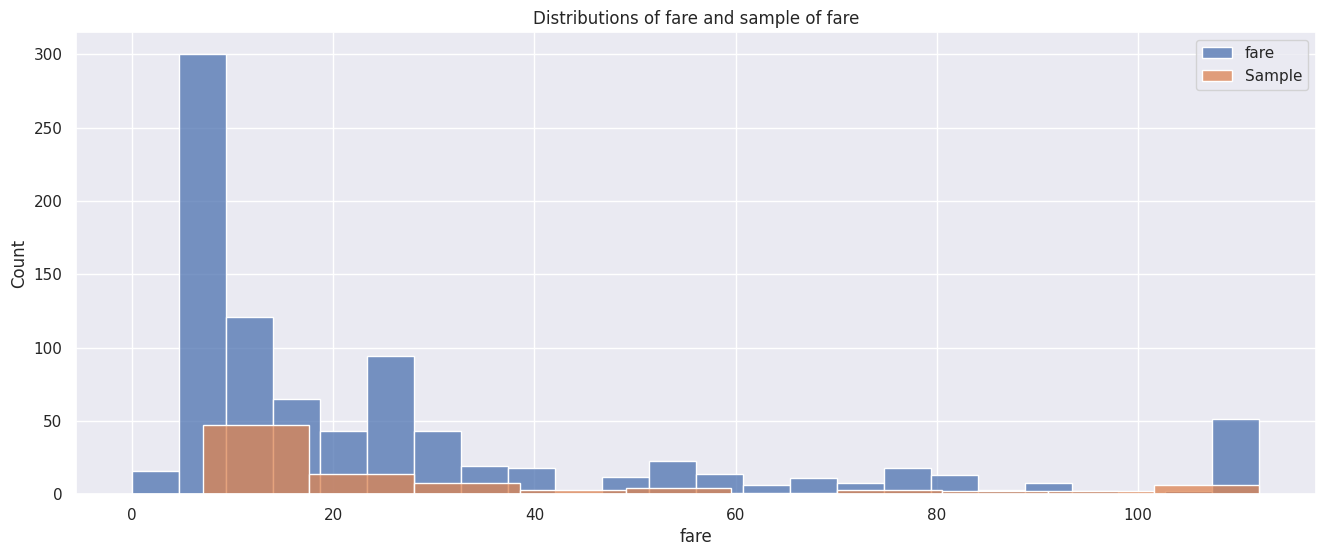

Source values 891
Sample values 90
Source mean 27.72048569023569
Sample mean 30.192498333333333


In [ ]:
column = 'fare'
column_sample = df_filtered[column][::10].values
print('Length of source', len(df_filtered[column]))
print('Length of sample', len(column_sample))
sns.histplot(df_filtered[column], label=column)
sns.histplot(column_sample, label='Sample')
plt.legend()
plt.title('Distributions of fare and sample of fare')
plt.show()
print('Source values', len(df_filtered[column]))
print('Sample values', len(column_sample))

print('Source mean', df_filtered[column].mean())
print('Sample mean', column_sample.mean())

We are interested in obtaining an estimate for the mean of fare and a confidence interval for it.

In [ ]:
sample_size = len(column_sample)//2
sample = np.random.choice(column_sample, size=sample_size, replace=True)

In [ ]:
n_iterations = 1000
sample_size = len(column_sample)//2
means = []
for i in range(n_iterations):
    sample = np.random.choice(column_sample, size=sample_size, replace=True)
    means.append(np.mean(sample))
means = np.array(means)
print('Bootstrap mean', np.mean(means))

Bootstrap mean 30.135593908888893


We can use the **bootstrap percentile method** of the sample means to obtain confidence intervals.

Let $\theta$ be the bootstrap sampled means.

For some width of confidence interval $p$, e.g. $95\%$:
1. Compute $\alpha$  as $1 - p$
2. Obtain the lower percentile $\alpha / 2$
3. Obtain the upper percentile $1 - \alpha/2$
4. Obtain the confidence interval: $[ percentile(\theta, \alpha / 2), percentile(\theta, 1- \alpha / 2) ]$

In [ ]:
p = 0.95
alpha = 1 - p
lower = np.percentile(means, (alpha/2)*100)
upper = np.percentile(means, (1-alpha/2)*100)
print(f'{round(p*100)}% confidence interval for the bootstrap mean: ({lower:2f}, {upper:2f})')

95% confidence interval for the bootstrap mean: (22.026707, 39.386813)


This method is the simplest one and it is most likely [the worst one](https://stats.stackexchange.com/questions/355781/is-it-true-that-the-percentile-bootstrap-should-never-be-used). It's known to produce poor results when the distribution of sampled statistic is skewed.

A less biased method is the **empirical bootstrap**. In that, you use the deviation of sample means from the mean of sample means to estimate the confidence interval.

1. Compute deviations of sample means from the mean $\delta = \{\theta_0 - \mathop{\mathbb{E}}[\theta], \theta_1 - \mathop{\mathbb{E}}[\theta], \dots \}$
2. Obtain the confidence interval: $[ \mathop{\mathbb{E}}[\theta] - percentile(\delta, 1 - \alpha / 2), \mathop{\mathbb{E}}[\theta] - percentile(\delta,  \alpha / 2) ]$

In the code cell below, compute the empirical bootstrap confidence interval for the mean of age.

In [ ]:
deviations = means - np.mean(means)
lower = np.mean(means) - np.percentile(deviations, (1-alpha/2)*100)
upper = np.mean(means) - np.percentile(deviations, (alpha/2)*100)
print(f'Empirical bootstrap {round(p*100)}% confidence interval for the bootstrap mean: ({lower:2f}, {upper:2f})')

Empirical bootstrap 95% confidence interval for the bootstrap mean: (20.884375, 38.244481)


### Solution:

In [ ]:
deviations = means - np.mean(means)
lower = np.mean(means) - np.percentile(deviations, (1-alpha/2)*100)
upper = np.mean(means) - np.percentile(deviations, (alpha/2)*100)
print(f'Empirical bootstrap {round(p*100)}% confidence interval for the bootstrap mean: ({lower:2f}, {upper:2f})')

## Getting a confidence interval for classifier accuracy with bootstrap

Imagine that there is some unknown population of our classifier accuracies. We want to get the mean of this population. We have a "samples" of our accuracies: results of fitting the classifier to some data and computing the accuracy on a validation set.

In [ ]:
X_train = X_train.values
y_train = y_train.values

100%|██████████| 100/100 [00:04<00:00, 21.67it/s]


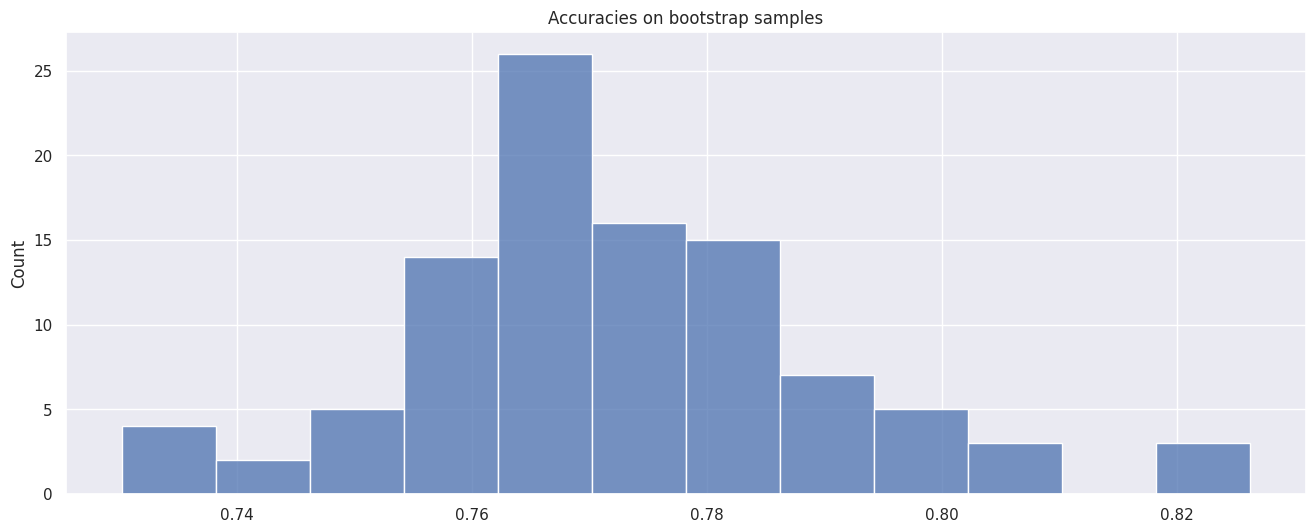

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

n_iterations = 100
n_size = len(X_train)//2
model = pipe

accuracies = []
for i in tqdm(range(n_iterations)):
    train_idx = resample(range(len(X_train)), n_samples=n_size)
    val_idx = np.array([i for i in range(len(X_train)) if i not in train_idx])

    model.fit(X_train[train_idx], y_train[train_idx])
    # evaluate model
    predictions = model.predict(X_train[val_idx])
    score = accuracy_score(y_train[val_idx], predictions)
    accuracies.append(score)

sns.histplot(accuracies)
plt.title('Accuracies on bootstrap samples')
plt.show()

In [ ]:
p = 0.95
alpha = 1 - p
lower = np.percentile(accuracies, (alpha/2)*100)
upper = np.percentile(accuracies, (1-alpha/2)*100)
print(f'Accuracy according to percentile bootstrap: ({lower:2f}, {upper:2f})')

Accuracy according to percentile bootstrap: (0.736550, 0.813835)


In [ ]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'True accuracy on test set: {accuracy:2f}')

True accuracy on test set: 0.791045


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
